Checking which GPU is being used in this session.

In [ ]:
! nvidia-smi

Thu Mar  4 07:15:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Introduction
We have taken heavy inspiration from the official [TensorFlow guide for NMT wiht Attention](https://www.tensorflow.org/tutorials/text/nmt_with_attention).
In this notebook we have tried documenting the code better with mathametical interpretations. We have also tried wrapping the custom `encoder` and `decoder` into a `tf.keras.Model` class upon which we can apply the `model.fit` method. 
> While TensoFlow uses unidirectional GRU for the encoder and decoder we go on to using Bi-directional layers. 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as L

import os
import numpy as np
tf.random.set_seed(666)
os.environ['PYTHONHASHSEED'] = str(666)
np.random.seed(666)

# Utilities And Downloads

We use `tf.keras.utils.get_file` to download the English to Spanish dataset hosted by Google.

In [ ]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

print(f"[INFO] PATH TO ZIP: {path_to_zip}")

2646016/2638744 [==============================] - 0s 0us/step
[INFO] PATH TO ZIP: /root/.keras/datasets/spa-eng.zip


In [ ]:
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

print(f"[INFO] PATH TO FILE: {path_to_file}")

[INFO] PATH TO FILE: /root/.keras/datasets/spa-eng/spa.txt


# Preprocessing functions
In the later snippets we use some functions that are used to pre-process the data.



In [ ]:
import unicodedata
import re

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn')

In [ ]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [ ]:
import io

In [ ]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [ ]:
en, sp = create_dataset(path_to_file, None)
print(en[100])
print(sp[100])

<start> go away ! <end>
<start> salga de aqui ! <end>


In [ ]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor,
        padding='post')

    return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    inp_lang, targ_lang = create_dataset(path , num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
num_examples = 70_000
(input_tensor,target_tensor,inp_lang,targ_lang) = load_dataset(path_to_file,num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
print(f'[INFO] Max length of target: {max_length_targ}')
print(f'[INFO] Max length of input: {max_length_inp}')

[INFO] Max length of target: 20
[INFO] Max length of input: 14


# Dataset
Here we use the `tf.data.Dataset` API for better dataset pipeline.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Creating training and validation sets using an 80-20 split
(input_tensor_train,input_tensor_val,target_tensor_train,target_tensor_val) = train_test_split(input_tensor,target_tensor,test_size=0.3)
(input_tensor_val,input_tensor_test,target_tensor_val,target_tensor_test) = train_test_split(input_tensor_val,target_tensor_val,test_size=0.6)

# Show length
print(f'[INFO] Input_Train: {input_tensor_train.shape} Target_Train: {target_tensor_train.shape}')
print(f'[INFO] Input_Val: {input_tensor_val.shape} Target_Val: {target_tensor_val.shape}')
print(f'[INFO] Input_Test: {input_tensor_test.shape} Target_Test: {target_tensor_test.shape}')

[INFO] Input_Train: (49000, 14) Target_Train: (49000, 20)
[INFO] Input_Val: (8400, 14) Target_Val: (8400, 20)
[INFO] Input_Test: (12600, 14) Target_Test: (12600, 20)


In [ ]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> i
29 ----> can
132 ----> still
266 ----> hear
32 ----> your
761 ----> voice
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
124 ----> todavia
46 ----> puedo
920 ----> oir
28 ----> tu
599 ----> voz
3 ----> .
2 ----> <end>


# NMT with Attention
In this section we discuss the implementation of attention with NMT.

In [ ]:
# GLOBAL VARIABLES
BUFFER_SIZE_TRAIN = len(input_tensor_train)
BUFFER_SIZE_VAL = len(input_tensor_val)
BATCH_SIZE = 1000
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 512
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

train_ds = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE_TRAIN)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

val_ds = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE_VAL)
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test)).shuffle(BUFFER_SIZE_VAL)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# check the shape
for en,sp in train_ds.take(1):
    print(sp.shape)
    print(en.shape)

(1000, 20)
(1000, 14)


## Encoder
Bahdanau suggested that the encoder should consist of a `Bi-directional` recurrent unit. For our implementation we use the `bidirection` layer along with the `GRU` layer.

An encoder takes a sentence as input, and provides with annotations. Let us break the formation of annotation in two parts.
1. Formation of the hidden states for a unidirectional recurrent unit. 
    $$
    h_{t}=f(h_{t-1},x_{t})\\
    \boxed{\Longrightarrow h_{t}=\tanh{(w_{h}h_{t-1}+W_{x}x_{t}+b)}}
    $$
    where 
    - $h_{t}$ is the present hidden state
    - $h_{t-1}$ is the previous hidden state
    - $x_{t}$ is the present input.
2. Concatenation of the forward hidden states and backward hidden state.
    We are using a `bidirectional` layer. This means that we have two set of hidden states, one for the forward     processing $\vec{h_{t}}$ and the other for the backward processing $\overleftarrow{h_{t}}$.
    Bahdanau suggest to concat the two set of hidden states and move ahead with our implementations. This concatenated hidden state is the `annotation`.
    $$
    h_{t}=[\vec{h};\overleftarrow{h}]
    $$

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self,
               vocab_size,
               embedding_dim,
               enc_units,
               batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = L.Embedding(vocab_size, embedding_dim)
    self.gru = L.GRU(self.enc_units,
                     return_sequences=True,
                     return_state=True,
                     recurrent_initializer='glorot_uniform')
    self.bidirection = L.Bidirectional(self.gru, merge_mode='concat')

  def call(self,
           x,
           hidden_fd,
           hidden_bd):
    x = self.embedding(x)
    enc_hidden_states, fd_state, bd_state = self.bidirection(x, initial_state = [hidden_fd, hidden_bd])
    return enc_hidden_states, fd_state, bd_state

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(2)]

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
initial_fwd, initial_bck = encoder.initialize_hidden_state()
for en, sp in train_ds.take(1):
    sample_enc_hidden_states, sample_hidden_fwd, sample_hidden_bck = encoder(en, initial_fwd, initial_bck)
    print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_enc_hidden_states.shape))
    print ('Encoder Hidden FWD state shape: (batch size, units) {}'.format(sample_hidden_fwd.shape))
    print ('Encoder Hidden FWD state shape: (batch size, units) {}'.format(sample_hidden_bck.shape))

Encoder output shape: (batch size, sequence length, units) (1000, 14, 2048)
Encoder Hidden FWD state shape: (batch size, units) (1000, 1024)
Encoder Hidden FWD state shape: (batch size, units) (1000, 1024)


## Attention and Decoder
In the two consecutive code blocks we would be building our Attention and Decoder model.

I have found it easier to approach the models from the decoder's point of view. Let's first describe a regular recurrent decoder and move into applying attention.

A regular decoder with recurrent units takes as input a fixed latent representation $c=f(\{h_{enc,1},h_{enc,2},...,h_{enc,T_{x}}\})$ which depends on the encoder hidden states, and label words $y_{t}$. We notice that $c$ the fixed latent representation is a static entity. This is also called the context vector that holds information of the entire source sentence in a compressed way.

Attention is a mechanism that helps in building the context vector $c$ for every step of the decoder. This time, we attend to important parts of the source sentence. This happens through a Dense model being learned end to end with the objective of good translation. The only differnece with regular decoder and a decoder with attention is that the context vector $c$ now is dynamic $c_{i}$ where $i$ indices all the decoding step.

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = L.Dense(units)
    self.W2 = L.Dense(units)
    self.V = L.Dense(1)

  def call(self, dec_hidden_state, annotations):
    dec_hidden_state_time = tf.expand_dims(dec_hidden_state, 1)

    score = self.V(tf.nn.tanh(
        self.W1(dec_hidden_state_time) + self.W2(annotations)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * annotations
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = L.Embedding(vocab_size, embedding_dim)
    self.gru = L.GRU(self.dec_units,
                     return_sequences=True,
                     return_state=True,
                     recurrent_initializer='glorot_uniform')
    self.fc = L.Dense(vocab_size)
    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, dec_hidden_state, annotations):
    context_vector, attention_weights = self.attention(dec_hidden_state, annotations)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

initial_fd, initial_bd = encoder.initialize_hidden_state()
for en,sp in train_ds.take(1):
    annotations, enc_fd_hidden, enc_bd_hidden = encoder(en, initial_fd, initial_bd)
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
    prediction, dec_hidden, att_weights = decoder(dec_input, enc_fd_hidden, annotations)

    print ('Prediction shape: (batch_size, vocab size) {}'.format(prediction.shape))
    print ('Decoder hidden state shape: (batch_size, GRU units) {}'.format(dec_hidden.shape))
    print ('Attention weights shape: (batch_size, inputs length, 1) {}'.format(att_weights.shape))

Prediction shape: (batch_size, vocab size) (1000, 16132)
Decoder hidden state shape: (batch_size, GRU units) (1000, 1024)
Attention weights shape: (batch_size, inputs length, 1) (1000, 14, 1)


# Model Class for easier training
Here we encapsulate the entire training process in a custom model. This is a good practise as this provides off the chart compatibility with a lot of features provided by tensorflow and keras.

In [ ]:
class NMT(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(NMT, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        # Every sentence is different
        # We would not want the memory state to flow from
        # one sentence to other
        enc_hidden_fd, enc_hidden_bd = self.encoder.initialize_hidden_state()
        inp, targ = data
        loss = 0
        with tf.GradientTape() as tape:
            annotations, enc_hidden_fd, _ = self.encoder(inp, enc_hidden_fd, enc_hidden_bd)
            dec_hidden = enc_hidden_fd
            dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, att_weights = self.decoder(dec_input, dec_hidden, annotations)
                loss += self.compiled_loss(targ[:, t], predictions)
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        batch_loss = (loss / int(targ.shape[1]))
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return {"custom_loss": batch_loss}
    
    def test_step(self, data):
        enc_hidden_fd, enc_hidden_bd = self.encoder.initialize_hidden_state()
        inp, targ = data
        loss = 0
        enc_output, enc_hidden_fd, _ = self.encoder(inp, enc_hidden_fd, enc_hidden_bd)
        dec_hidden = enc_hidden_fd
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, att_weights = self.decoder(dec_input, dec_hidden, annotations)
            loss += self.compiled_loss(targ[:, t], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
        batch_loss = (loss / int(targ.shape[1]))
        return {"custom_loss": batch_loss}

In [ ]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_custom_loss", patience=5, verbose=2, restore_best_weights=True)

In [ ]:
EPOCHS=100
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

main_model = NMT(encoder, decoder)
main_model.compile(loss=loss_function, optimizer=optimizer)

history = main_model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[es],
    epochs=EPOCHS)

Epoch 1/100
49/49 [==============================] - 89s 1s/step - custom_loss: 1.9595 - val_custom_loss: 2.9688
Epoch 2/100
49/49 [==============================] - 65s 1s/step - custom_loss: 1.5482 - val_custom_loss: 2.6008
Epoch 3/100
49/49 [==============================] - 65s 1s/step - custom_loss: 1.4574 - val_custom_loss: 2.5293
Epoch 4/100
49/49 [==============================] - 65s 1s/step - custom_loss: 1.3755 - val_custom_loss: 2.4728
Epoch 5/100
49/49 [==============================] - 65s 1s/step - custom_loss: 1.3031 - val_custom_loss: 2.4493
Epoch 6/100
49/49 [==============================] - 65s 1s/step - custom_loss: 1.2178 - val_custom_loss: 2.3627
Epoch 7/100
49/49 [==============================] - 65s 1s/step - custom_loss: 1.1433 - val_custom_loss: 2.3492
Epoch 8/100
49/49 [==============================] - 65s 1s/step - custom_loss: 1.0765 - val_custom_loss: 2.3604
Epoch 9/100
49/49 [==============================] - 65s 1s/step - custom_loss: 1.0150 - val_cus

In [ ]:
import matplotlib.pyplot as plt

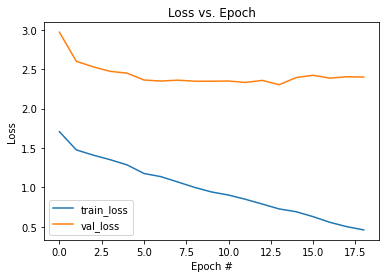

In [ ]:
plt.plot(history.history["custom_loss"], label="train_loss")
plt.plot(history.history["val_custom_loss"], label="val_loss")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

> A basic thing to notice here is the gap between the validation and the training loss. This indicates to the scope of parameters that can be inserted to better train the model.

In [ ]:
custom_test_loss = main_model.evaluate(test_ds)
print(f'[INFO] Test Loss: {custom_test_loss}')

12/12 [==============================] - 5s 410ms/step - custom_loss: 2.3574
[INFO] Test Loss: 2.3491790294647217


# Inference
The inference module holds the code snippet to have translations from english to spanish. We also plot the attention weights of the translations. The attention weights are pretty neat to build intuitions.

In [ ]:
encoder = main_model.encoder
decoder = main_model.decoder

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_inp,padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    encoder_hidden_fwd = tf.zeros((1, units))
    encoder_hidden_bck = tf.zeros((1, units))
    enc_out, enc_hidden_fwd, encoder_hidden_bck = encoder(inputs, encoder_hidden_fwd, encoder_hidden_bck)

    dec_hidden = enc_hidden_fwd
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,dec_hidden,enc_out)
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence):

    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
import matplotlib.ticker as ticker

Input: <start> how are you ? <end>
Predicted translation: ¿ como son ? <end> 


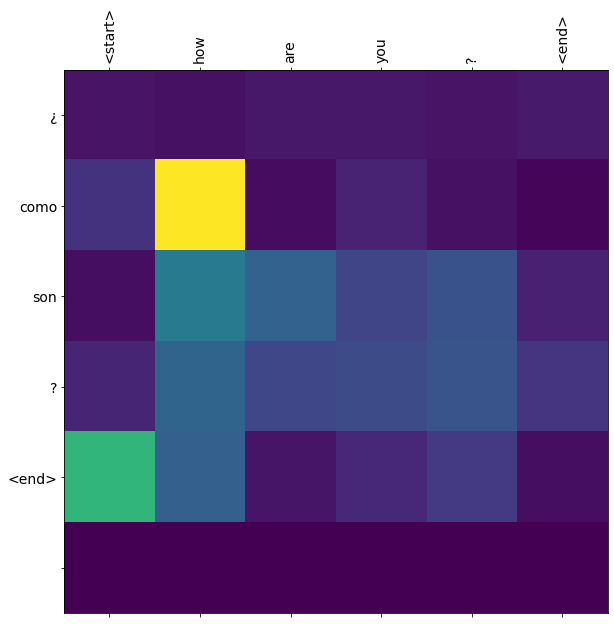

In [ ]:
translate(u'how are you?')

Input: <start> i am good . <end>
Predicted translation: estoy muy ingenuo . <end> 


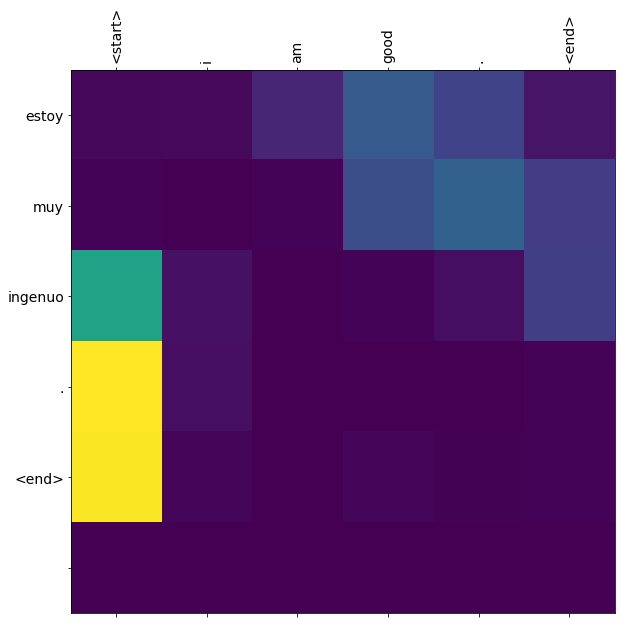

In [ ]:
translate(u'i am good.')

Input: <start> i am going to school <end>
Predicted translation: voy a la escuela . <end> 


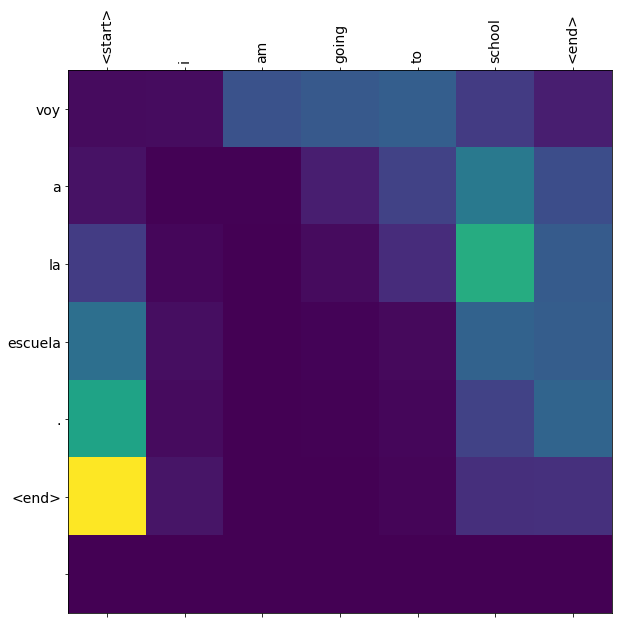

In [ ]:
translate(u'i am going to school')

Input: <start> let us go home now <end>
Predicted translation: dejame gracias por que tu ayuda a tom en casa . <end> 


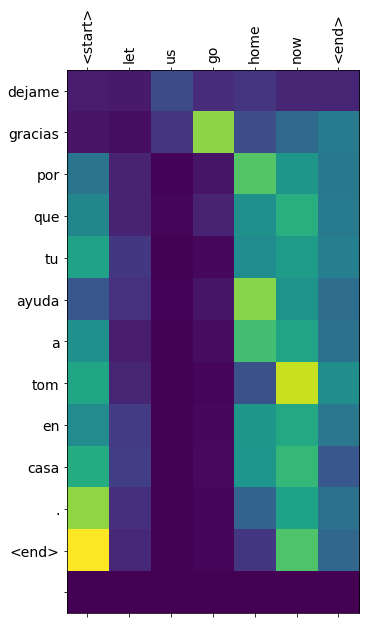

In [ ]:
translate(u'let us go home now')

Input: <start> why would you do this ? <end>
Predicted translation: ¿ por que no te ha hecho ? <end> 


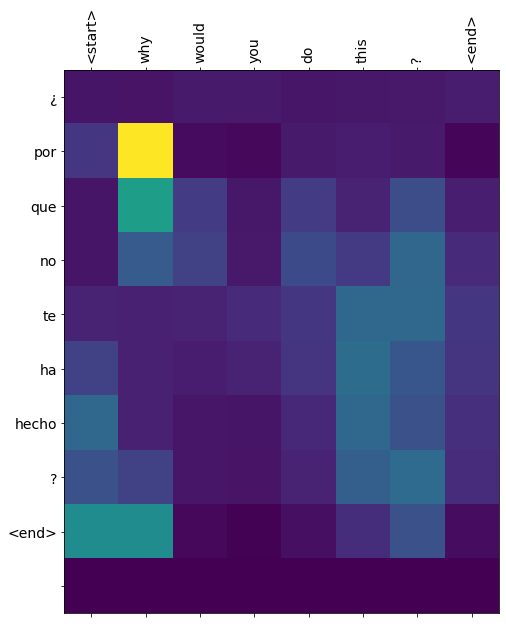

In [ ]:
translate(u'why would you do this?')

Input: <start> do you want to see some magic ? <end>
Predicted translation: ¿ quieres algo de mi ? <end> 


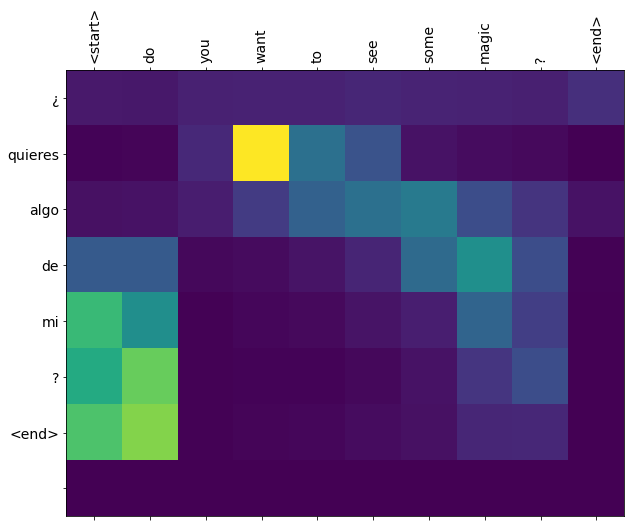

In [ ]:
translate(u'do you want to see some magic?')